In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import sys
print(sys.executable)

/Users/spacehunter/miniconda/envs/point72/bin/python


In [3]:
nyc_map = 'MODZCTA_20250409.geojson'
gdf = gpd.read_file(nyc_map)

In [4]:
income_data = pd.read_csv('ACSST5Y2023.S1903_2025-04-09T104535/ACSST5Y2023.S1903-Data.csv')

In [5]:
# Select the two columns from income_data
income_df = income_data[['NAME', 'S1903_C03_015E']]

# Rename columns for better readability
income_df = income_df.rename(columns={
    'NAME': 'ZCTA', 
    'S1903_C03_015E': 'Median_Household_Income'
})

# Skip the first row which contains column descriptions
income_df = income_df.iloc[1:]

# Preview the first few rows of the result
print(income_df.head())

          ZCTA Median_Household_Income
1  ZCTA5 10001                  182117
2  ZCTA5 10002                   51093
3  ZCTA5 10003                250,000+
4  ZCTA5 10004                250,000+
5  ZCTA5 10005                250,000+


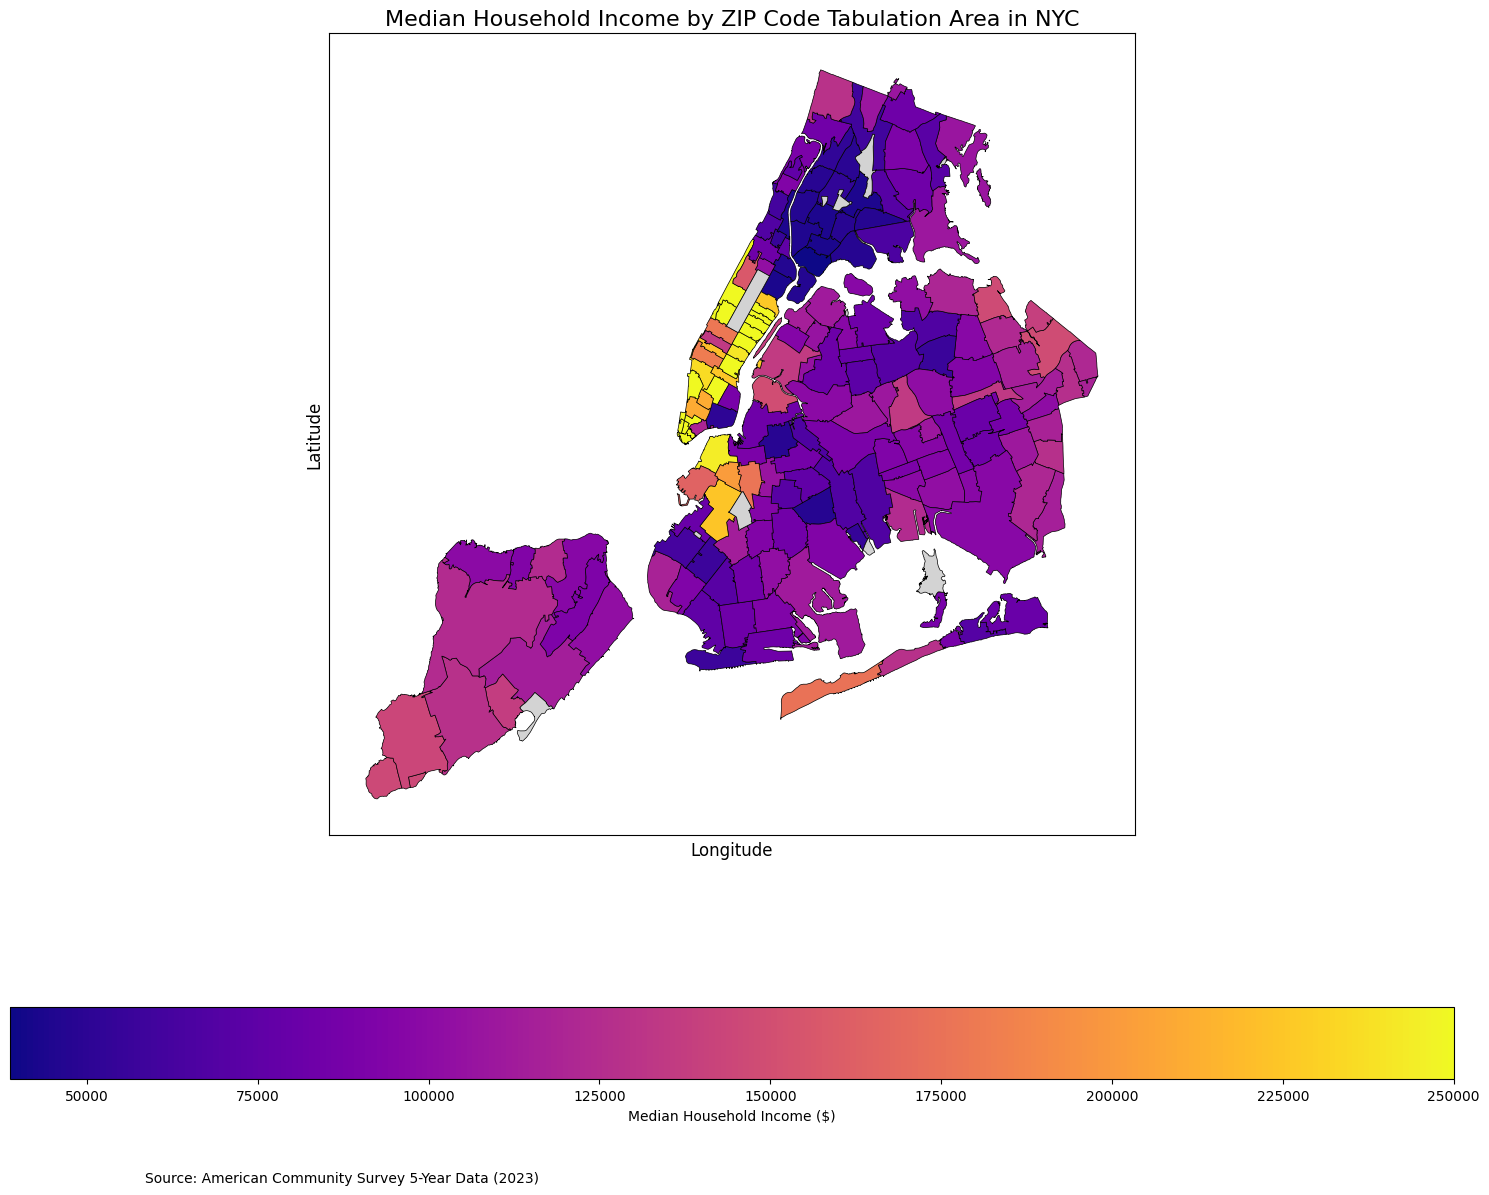

In [6]:
# Clean income_df - extract just the ZIP code from the ZCTA name and convert income to numeric
income_df['ZCTA'] = income_df['ZCTA'].str.extract(r'ZCTA5\s(\d+)')
income_df['Median_Household_Income'] = income_df['Median_Household_Income'].replace('250,000+', '250000')
income_df['Median_Household_Income'] = pd.to_numeric(income_df['Median_Household_Income'], errors='coerce')

# Prepare GDF for merging
# MODZCTA is Modified ZCTA
gdf['ZCTA'] = gdf['modzcta'].astype(str)

# Merge geospatial data with income data
merged_gdf = gdf.merge(income_df, on='ZCTA', how='left')

# Create a choropleth map of median household income
fig, ax = plt.subplots(1, figsize=(15, 12))

# Plot the map with income data
merged_gdf.plot(
    column='Median_Household_Income',
    ax=ax,
    legend=True,
    cmap='plasma',
    legend_kwds={'label': 'Median Household Income ($)', 'orientation': 'horizontal'},
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    edgecolor='black',
    linewidth=0.5,
    
)

# Add title and labels
ax.set_title('Median Household Income by ZIP Code Tabulation Area in NYC', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Remove axis ticks for a cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Add source information
plt.figtext(0.1, 0.01, "Source: American Community Survey 5-Year Data (2023)", fontsize=10)

plt.tight_layout()
plt.show()

In [8]:
# Read the social characteristics data
social_data = pd.read_csv('ACSDP5Y2023.DP02_2025-04-09T124018/ACSDP5Y2023.DP02-Data.csv')

# Get column metadata to identify the right columns
social_columns = pd.read_csv('ACSDP5Y2023.DP02_2025-04-09T124018/ACSDP5Y2023.DP02-Column-Metadata.csv')

# Find columns for educational attainment - Bachelor's degree or higher
bachelor_higher_column = 'DP02_0068E'  # Based on metadata: "Estimate!!EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher"

# Select relevant columns from social data
edu_df = social_data[['NAME', bachelor_higher_column]]

# Rename columns for better readability
edu_df = edu_df.rename(columns={
    'NAME': 'ZCTA',
    bachelor_higher_column: 'Bachelors_Degree_or_Higher'
})

# Skip the first row which contains column descriptions
edu_df = edu_df.iloc[1:]

# Clean edu_df - extract just the ZIP code from the ZCTA name and convert education numbers to numeric
edu_df['ZCTA'] = edu_df['ZCTA'].str.extract(r'ZCTA5\s(\d+)')
edu_df['Bachelors_Degree_or_Higher'] = pd.to_numeric(edu_df['Bachelors_Degree_or_Higher'], errors='coerce')

# Merge education data with the existing merged_gdf
merged_gdf = merged_gdf.merge(edu_df, on='ZCTA', how='left')

# Preview the updated dataframe
print(merged_gdf[['ZCTA', 'Median_Household_Income', 'Bachelors_Degree_or_Higher']].head())

    ZCTA  Median_Household_Income  Bachelors_Degree_or_Higher
0  10001                 182117.0                     16248.0
1  10002                  51093.0                     23146.0
2  10003                 250000.0                     30039.0
3  10026                 103169.0                     14633.0
4  10004                 250000.0                      2736.0


/var/folders/92/b4ww7hzd5bd380sl60bc24m80000gn/T/ipykernel_33676/3809520212.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

In [10]:
#save the merged data to a new file
output_file = 'cleaned_data/merged_income_education_data.geojson'
merged_gdf.to_file(output_file, driver='GeoJSON')

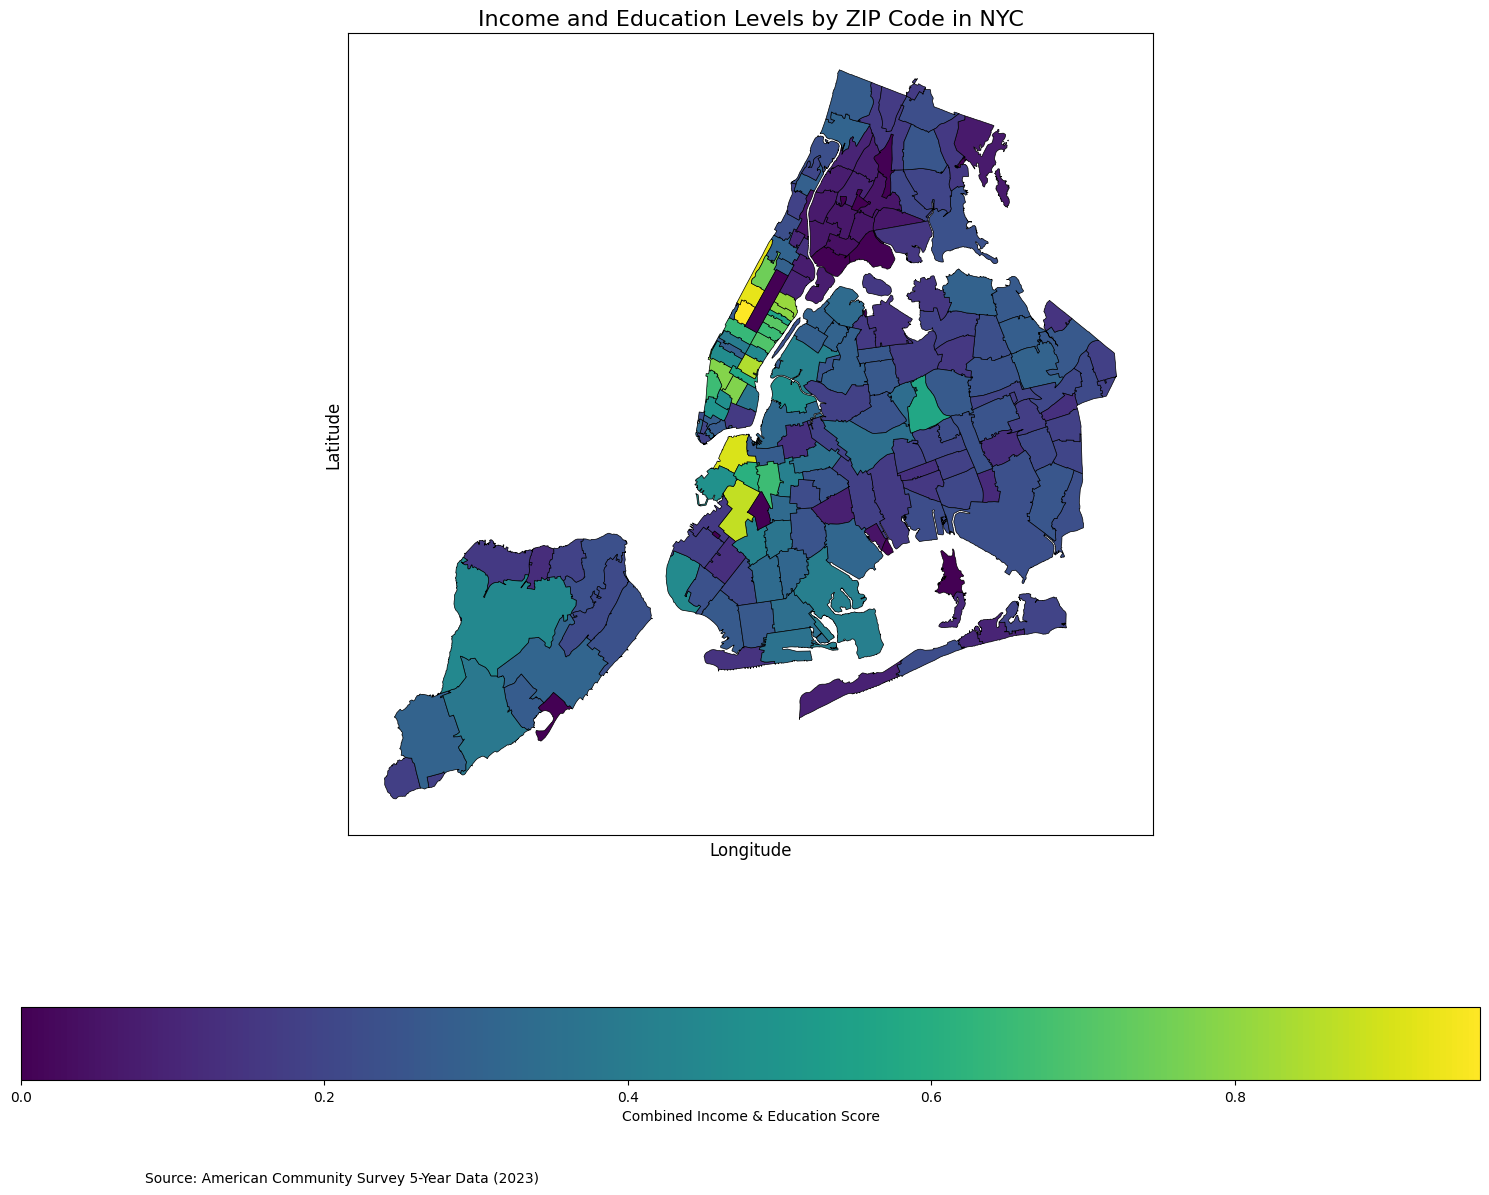

In [ ]:
# Create a composite score that combines income and education levels
# First, normalize the data to a 0-1 scale for both variables
merged_gdf['Income_Normalized'] = (merged_gdf['Median_Household_Income'] - merged_gdf['Median_Household_Income'].min()) / \
                                 (merged_gdf['Median_Household_Income'].max() - merged_gdf['Median_Household_Income'].min())

merged_gdf['Education_Normalized'] = (merged_gdf['Bachelors_Degree_or_Higher'] - merged_gdf['Bachelors_Degree_or_Higher'].min()) / \
                                   (merged_gdf['Bachelors_Degree_or_Higher'].max() - merged_gdf['Bachelors_Degree_or_Higher'].min())

# Fill NAs with 0 to avoid errors
merged_gdf['Income_Normalized'] = merged_gdf['Income_Normalized'].fillna(0)
merged_gdf['Education_Normalized'] = merged_gdf['Education_Normalized'].fillna(0)

# Create a composite score (geometric mean of both metrics)
merged_gdf['Affluence_Education_Score'] = np.sqrt(merged_gdf['Income_Normalized'] * merged_gdf['Education_Normalized'])

# Create the plot
fig, ax = plt.subplots(1, figsize=(15, 12))

# Plot the map with the combined score
merged_gdf.plot(
    column='Affluence_Education_Score',
    ax=ax,
    legend=True,
    cmap='viridis',  # viridis is good for showing intensity
    legend_kwds={
        'label': 'Combined Income & Education Score',
        'orientation': 'horizontal'
    },
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    edgecolor='black',
    linewidth=0.5,
)

# Add title and labels
ax.set_title('Income and Education Levels by ZIP Code in NYC', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Remove axis ticks for a cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Add source information
plt.figtext(0.1, 0.01, "Source: American Community Survey 5-Year Data (2023)", fontsize=10)

plt.tight_layout()
plt.show()

    ZCTA  Total_Population  Population_25_to_44  Percent_25_to_44  \
0  10001           29079.0              12837.0              44.1   
1  10002           75517.0              23613.0              31.3   
2  10003           53825.0              19184.0              35.6   
3  10026           37113.0              13630.0              36.7   
4  10004            3875.0               2046.0              52.8   

   Percent_White  Percent_Asian  
0           54.7           18.0  
1           31.2           36.7  
2           67.2           17.9  
3           26.5            6.4  
4           63.5           23.8  


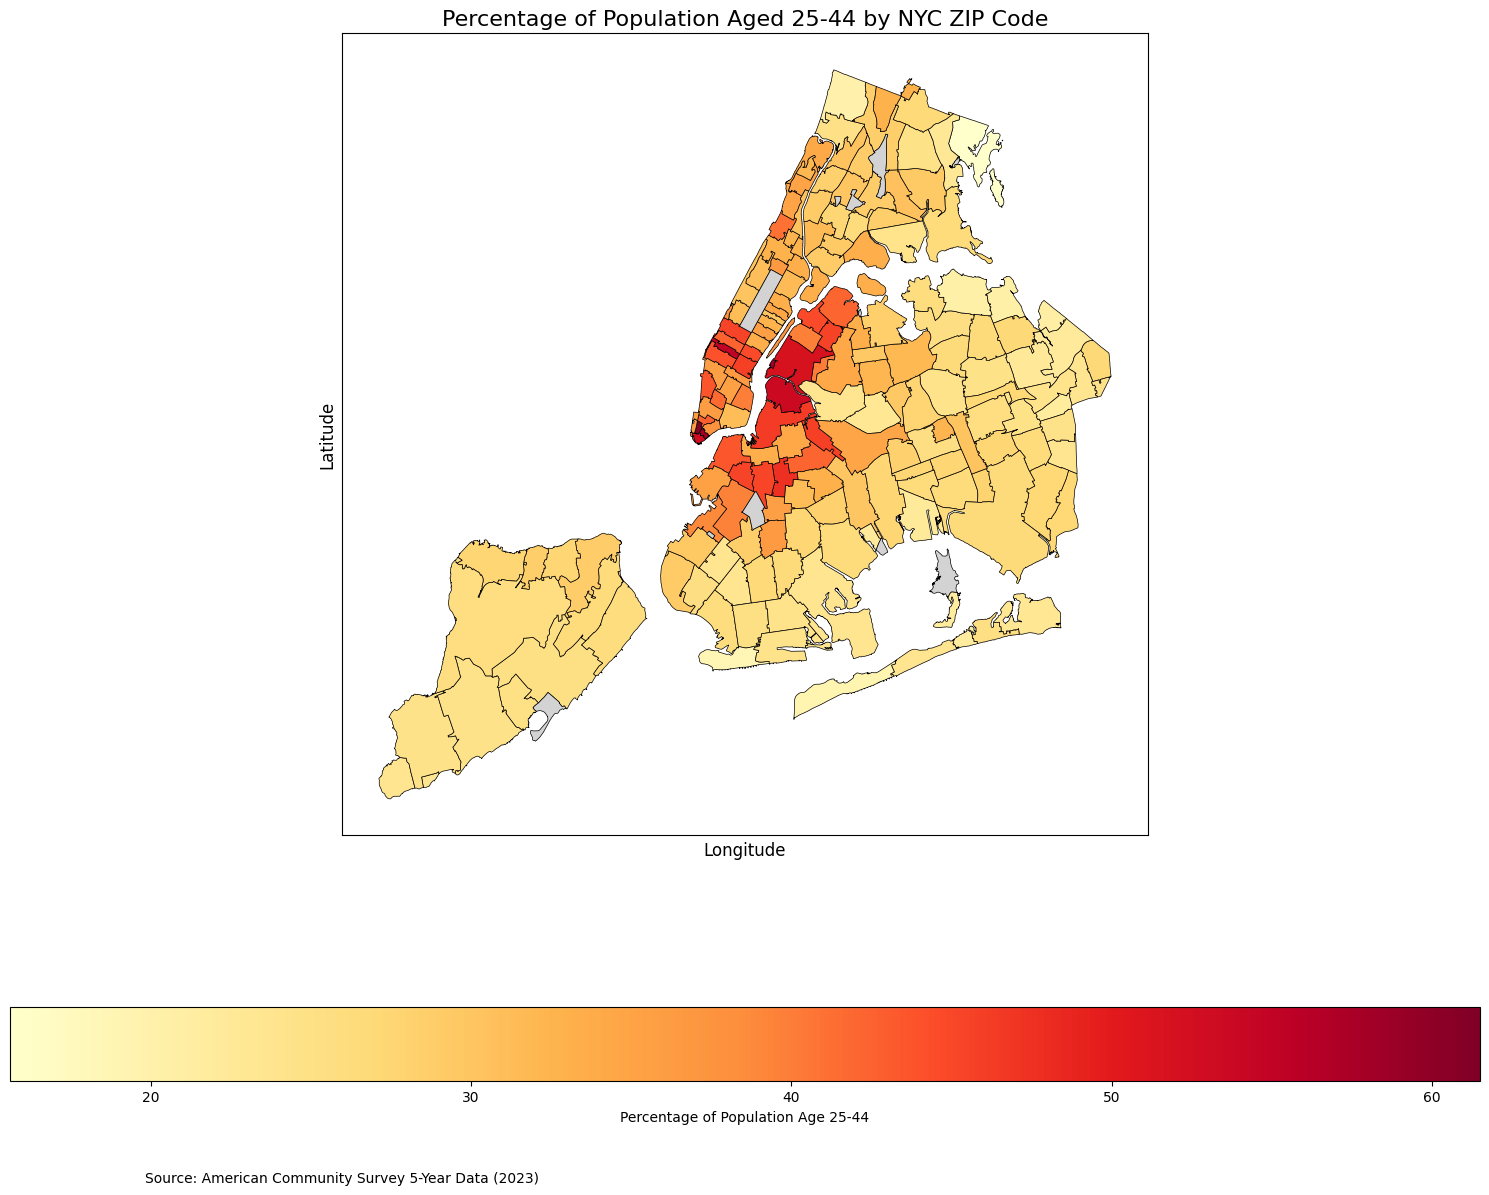

In [ ]:
# Read the demographic data file
demographic_data = pd.read_csv('ACSDP5Y2023.DP05_2025-04-09T124250/ACSDP5Y2023.DP05-Data.csv')

# Read column metadata for reference
demographic_columns = pd.read_csv('ACSDP5Y2023.DP05_2025-04-09T124250/ACSDP5Y2023.DP05-Column-Metadata.csv')

# Find relevant column descriptions for age groups and race
# DP05_0001E: Total population
# DP05_0010E: Population 25 to 34 years
# DP05_0011E: Population 35 to 44 years
# DP05_0037E: White population
# DP05_0047E: Asian population

# Select and extract relevant columns
demo_df = demographic_data[['NAME', 'DP05_0001E', 'DP05_0010E', 'DP05_0011E', 'DP05_0037E', 'DP05_0047E']]

# Skip the first row which contains column descriptions
demo_df = demo_df.iloc[1:]

# Rename columns for better readability
demo_df = demo_df.rename(columns={
    'NAME': 'ZCTA',
    'DP05_0001E': 'Total_Population',
    'DP05_0010E': 'Population_25_to_34',
    'DP05_0011E': 'Population_35_to_44',
    'DP05_0037E': 'White_Population',
    'DP05_0047E': 'Asian_Population'
})

# Extract just the ZIP code from the ZCTA name
demo_df['ZCTA'] = demo_df['ZCTA'].str.extract(r'ZCTA5\s(\d+)')

# Convert numeric columns to numeric type
for col in ['Total_Population', 'Population_25_to_34', 'Population_35_to_44', 'White_Population', 'Asian_Population']:
    demo_df[col] = pd.to_numeric(demo_df[col], errors='coerce')

# Calculate the total young adult population (25-44)
demo_df['Population_25_to_44'] = demo_df['Population_25_to_34'] + demo_df['Population_35_to_44']

# Calculate percentages
demo_df['Percent_25_to_44'] = (demo_df['Population_25_to_44'] / demo_df['Total_Population'] * 100).round(1)
demo_df['Percent_White'] = (demo_df['White_Population'] / demo_df['Total_Population'] * 100).round(1)
demo_df['Percent_Asian'] = (demo_df['Asian_Population'] / demo_df['Total_Population'] * 100).round(1)

# Merge with the existing merged geodataframe to add this data
merged_gdf = merged_gdf.merge(demo_df[['ZCTA', 'Total_Population', 'Population_25_to_44', 
                                      'Percent_25_to_44', 'White_Population', 'Asian_Population',
                                      'Percent_White', 'Percent_Asian']], 
                              on='ZCTA', how='left')

# Display the first few rows to verify the data
print(merged_gdf[['ZCTA', 'Total_Population', 'Population_25_to_44', 'Percent_25_to_44', 
                 'Percent_White', 'Percent_Asian']].head())

# Create a visualization of young adult population
fig, ax = plt.subplots(1, figsize=(15, 12))

# Plot the map showing percentage of population aged 25-44
merged_gdf.plot(
    column='Percent_25_to_44',
    ax=ax,
    legend=True,
    cmap='YlOrRd',  # Yellow-Orange-Red colormap
    legend_kwds={'label': 'Percentage of Population Age 25-44', 'orientation': 'horizontal'},
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    edgecolor='black',
    linewidth=0.5
)

# Add title and labels
ax.set_title('Percentage of Population Aged 25-44 by NYC ZIP Code', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Remove axis ticks for a cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Add source information
plt.figtext(0.1, 0.01, "Source: American Community Survey 5-Year Data (2023)", fontsize=10)

plt.tight_layout()
plt.show()

In [3]:
# Save the final merged geodataframe to a new file
output_file = 'cleaned_data/merged_final_data.geojson'
merged_gdf.to_file(output_file, driver='GeoJSON')

Loaded data with 178 ZIP codes
Columns available: ['modzcta', 'label', 'zcta', 'pop_est', 'ZCTA', 'Median_Household_Income', 'Bachelors_Degree_or_Higher', 'Income_Normalized', 'Education_Normalized', 'Affluence_Education_Score', 'Total_Population', 'Population_25_to_44', 'Percent_25_to_44', 'White_Population', 'Asian_Population', 'Percent_White', 'Percent_Asian', 'geometry']


/var/folders/92/b4ww7hzd5bd380sl60bc24m80000gn/T/ipykernel_39888/2294941680.py:10: DtypeWarning: Columns (2,3,4,5,6,7,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,204,205,206,207,208,209,210,211,212,213,214,215,216,217,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,

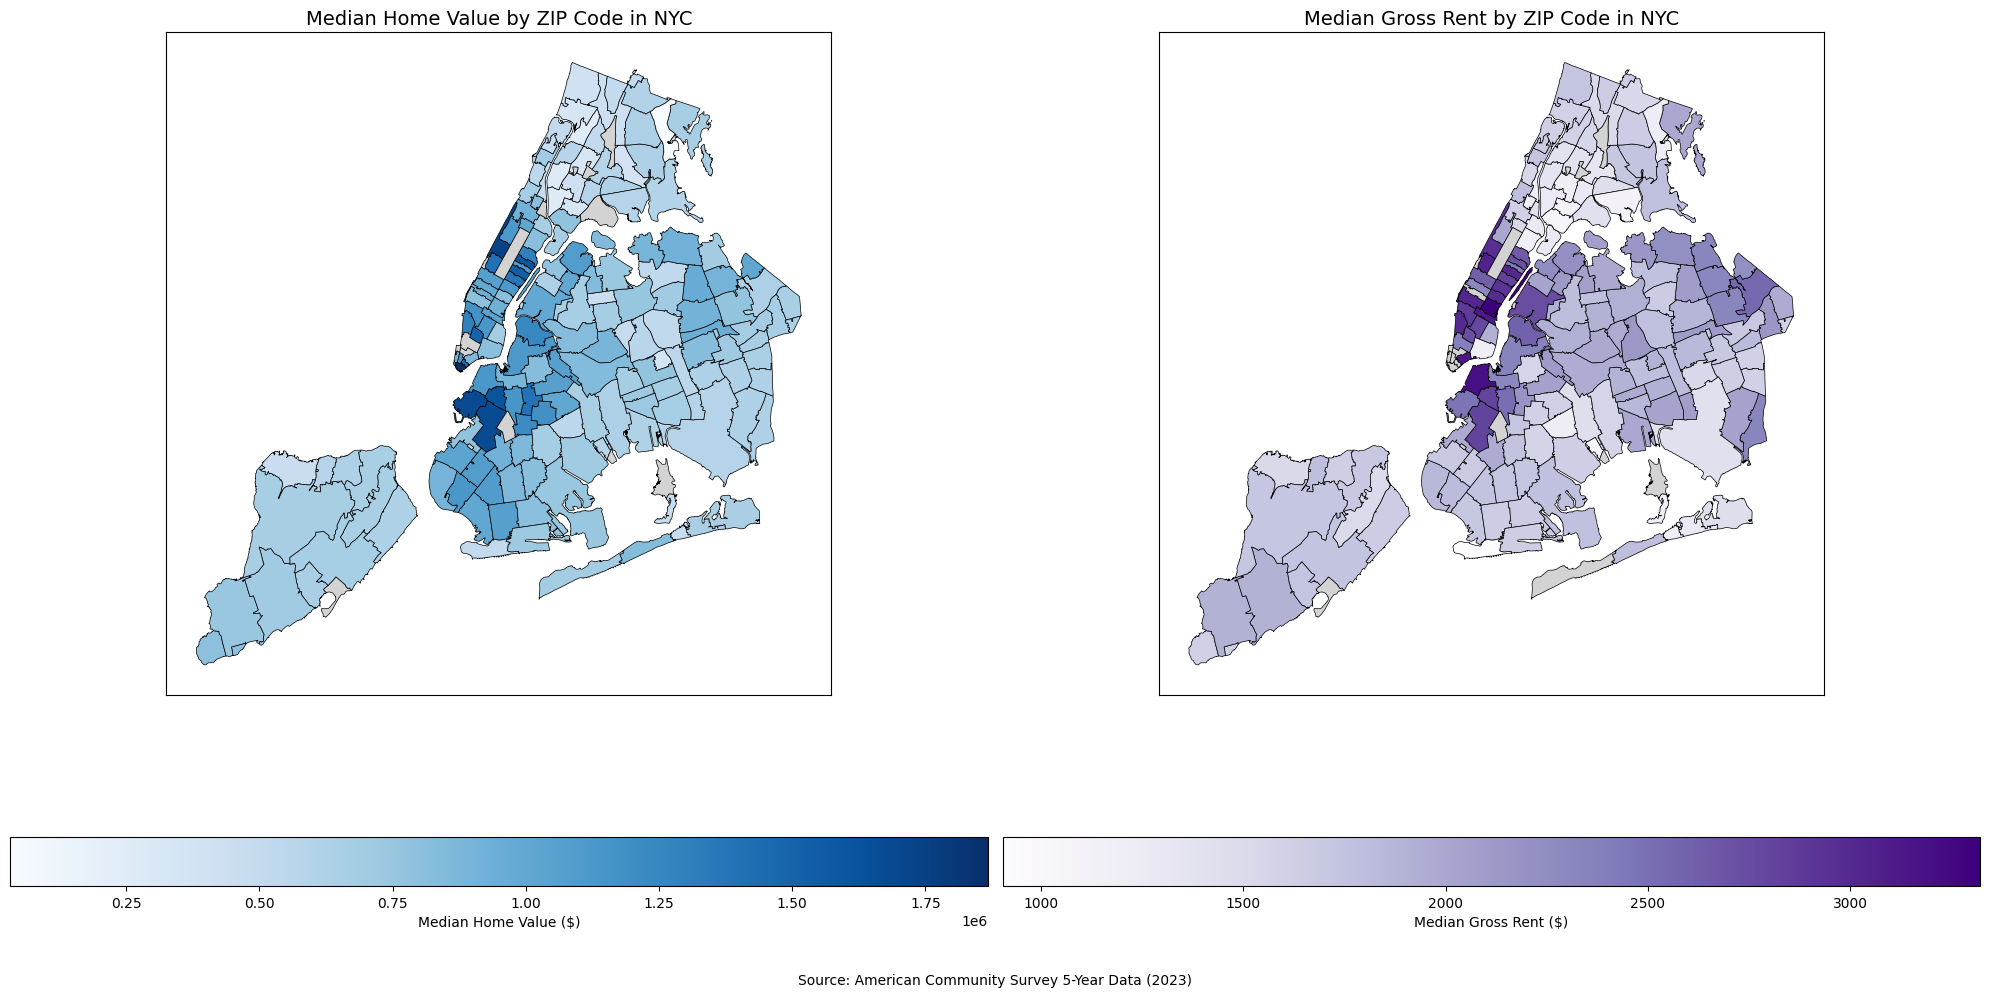

Median Home Value Statistics:
count    1.710000e+02
mean     8.077064e+05
std      3.095203e+05
min      3.190000e+04
25%      6.264000e+05
50%      7.319000e+05
75%      9.917500e+05
max      1.866400e+06
Name: Median_Home_Value, dtype: float64

Median Gross Rent Statistics:
count     167.000000
mean     1917.796407
std       514.081466
min       905.000000
25%      1608.000000
50%      1795.000000
75%      2142.000000
max      3321.000000
Name: Median_Gross_Rent, dtype: float64


In [2]:
# Read the merged data from the GeoJSON file
merged_gdf = gpd.read_file('cleaned_data/merged_final_data.geojson')

# Checking to make sure the data loaded properly
print(f"Loaded data with {len(merged_gdf)} ZIP codes")
print(f"Columns available: {merged_gdf.columns.tolist()}")


# Read the housing characteristics data
housing_data = pd.read_csv('ACSDP5Y2023.DP04_2025-04-09T161430/ACSDP5Y2023.DP04-Data.csv')

# Select columns for median housing value and median rent
housing_df = housing_data[['NAME', 'DP04_0089E', 'DP04_0134E']]

# Rename columns for better readability
housing_df = housing_df.rename(columns={
    'NAME': 'ZCTA',
    'DP04_0089E': 'Median_Home_Value',
    'DP04_0134E': 'Median_Gross_Rent'
})

# Skip the first row which contains column descriptions
housing_df = housing_df.iloc[1:]

# Clean housing_df - extract just the ZIP code from the ZCTA name and convert to numeric
housing_df['ZCTA'] = housing_df['ZCTA'].str.extract(r'ZCTA5\s(\d+)')
housing_df['Median_Home_Value'] = pd.to_numeric(housing_df['Median_Home_Value'], errors='coerce')
housing_df['Median_Gross_Rent'] = pd.to_numeric(housing_df['Median_Gross_Rent'], errors='coerce')

# Merge housing data with the existing geodataframe
merged_gdf = merged_gdf.merge(housing_df, on='ZCTA', how='left')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Median Home Value
merged_gdf.plot(
    column='Median_Home_Value',
    ax=ax1,
    legend=True,
    cmap='Blues',
    legend_kwds={'label': 'Median Home Value ($)', 'orientation': 'horizontal'},
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    edgecolor='black',
    linewidth=0.5
)

ax1.set_title('Median Home Value by ZIP Code in NYC', fontsize=14)
ax1.set_xticks([])
ax1.set_yticks([])

# Plot 2: Median Gross Rent
merged_gdf.plot(
    column='Median_Gross_Rent',
    ax=ax2,
    legend=True,
    cmap='Purples',
    legend_kwds={'label': 'Median Gross Rent ($)', 'orientation': 'horizontal'},
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    edgecolor='black',
    linewidth=0.5
)

ax2.set_title('Median Gross Rent by ZIP Code in NYC', fontsize=14)
ax2.set_xticks([])
ax2.set_yticks([])

# Add source information
plt.figtext(0.5, 0.01, "Source: American Community Survey 5-Year Data (2023)", fontsize=10, ha='center')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Median Home Value Statistics:")
print(merged_gdf['Median_Home_Value'].describe())
print("\nMedian Gross Rent Statistics:")
print(merged_gdf['Median_Gross_Rent'].describe())